# Introduction

## Motivation

This notebook follows up `model_options.ipynb`.

The key difference is that we filter using the category distance metric (see `bin/wp-get-links` for details), rather than relying solely on the regression to pick relevant articles. Thus, we want to decide what an appropriate category distance threshold is.

Our hope is that by adding this filter, we can now finalize the regression algorithm selection and configuration.

## Summary

(You may want to read this section last, as it refers to the full analysis below.)

### Q1. Which algorithm?

In `model_options`, we boiled down the selection to three choices:

1. Lasso, normalized, positive, auto 𝛼 (LA_NPA)
2. Elastic net, normalized, positive, auto 𝛼, auto 𝜌 (EN_NPAA)
3. Elastic net, normalized, positive, auto 𝛼, manual 𝜌 = ½ (EN_NPAM)

The results below suggest three conclusions:

1. LA_NPA vs. EN_NPAA:
   * EN_NPAA has (probably insignificantly) better RMSE.
   * Forecasts look almost identical.
   * EN_NPAA chooses a more reasonable-feeling number of articles.
   * EN_NPAA is more principled (lasso vs. elastic net).
2. EN_NPAM vs. EN_NPAA:
   * EN_NPAA has better RMSE.
   * Forecasts look almost identical, except EN_NPAM has some spikes in the 2014–2015 season, which probably accounts for the RMSE difference.
   * EN_NPAA chooses fewer articles, though EN_NPAM does not feel excessive.
   * EN_NPAA is more principles (manual 𝜌 vs. auto).
   
On balance, **EN_NPAA seems the best choice**, based on principles and article quantity rather than results, which are nearly the same across the board.

### Q2. What distance threshold?

Observations for EN_NPAA at distance threshold 1, 2, 3:

* d = 2 is where RMSE reaches its minimum, and it stays more or less the same all the way through d = 8.
* d = 2 and 3 have nearly identical-looking predictions.
* d = 2 and 3 have very similar articles and coefficient ranking. Of the 10 and 13 articles respectively, 9 are shared and in almost the same order.

These suggests that the actual models for d = 2..8 are very similar. Further:

* d = 2 or 3 does not have the spikes in 3rd season that d = 1 does. This suggests that the larger number of articles gives a more robust model.
* d = 2 or 3 matches the overall shape of the outbreak better than d = 1, though the latter gets the peak intensity more correct in the 1st season.

Finally, examining the article counts in `COUNTS` and `COUNTS_CUM`, d = 2 would give very small input sets in some of the sparser cases, while d = 3 seems safer (e.g., "es+Infecciones por clamidias" and "he+שעלת"). On the other hand, Arabic seems to have a shallower category structure, and d = 3 would capture most articles.

On balance, **d = 3 seems the better choice**. It performs as well as d = 2, without catching irrelevant articles, and d = 2 seems too few articles in several cases. The Arabic situation is a bit of an unknown, as none of us speak Arabic, but erring on the side of too many articles seems less risky than clearly too few.

### Q3. What value of 𝜌?

In both this notebook and `model_options`, every auto-selected 𝜌 has been 0.9, i.e., mostly lasso. Thus, we will **fix 𝜌 = 0.9** for performance reasons.

### Conclusion

We select **EN_NPAM with 𝜌 = 0.9**.

# Preamble

## Imports

In [1]:
%matplotlib inline

import collections
import gzip
import pickle
import os
import urllib.parse

import numpy as np
import matplotlib as plt
import pandas as pd
import sklearn as sk
import sklearn.linear_model

DATA_PATH = os.environ['WEIRD_AL_YANKOVIC']
plt.rcParams['figure.figsize'] = (12, 4)

## Load, preprocess, and clean data

Load and preprocess the truth spreadsheet.

In [2]:
truth = pd.read_excel(DATA_PATH + '/truth.xlsx', index_col=0)
TRUTH_FLU = truth.loc[:,'us+influenza']  # pull Series
TRUTH_FLU.index = TRUTH_FLU.index.to_period('W-SAT')
TRUTH_FLU.head()

start
2010-07-04/2010-07-10    0.941927
2010-07-11/2010-07-17    0.880415
2010-07-18/2010-07-24    0.842615
2010-07-25/2010-07-31    0.858382
2010-08-01/2010-08-07    0.833830
Freq: W-SAT, Name: us+influenza, dtype: float64

Load the Wikipedia link data. We convert percent-encoded URLs to Unicode strings for convenience of display.

In [3]:
def unquote(url):
   (lang, url) = url.split('+', 1)
   url = urllib.parse.unquote(url)
   url = url.replace('_', ' ')
   return (lang + '+' + url)

In [4]:
raw_graph = pickle.load(gzip.open(DATA_PATH + '/articles/wiki-graph.pkl.gz'))
GRAPH = dict()
for root in raw_graph.keys():
   unroot = unquote(root)
   GRAPH[unroot] = { unquote(a): d for (a, d) in raw_graph[root].items() }

Load all the time series. Most of the 4,299 identified articles were in the data set.

Note that in contrast to `model_options`, we do not remove any time series by the fraction that they are zero. The results seem good anyway. This filter also may not apply well to the main experiment, because the training periods are often not long enough to make it meaningful.

In [5]:
TS_ALL = pd.read_csv(DATA_PATH + '/tsv/forecasting_W-SAT.norm.tsv',
                     sep='\t', index_col=0, parse_dates=True)
TS_ALL.index = TS_ALL.index.to_period('W-SAT')
TS_ALL.rename(columns=lambda x: unquote(x[:-5]), inplace=True)
len(TS_ALL.columns)

4179

In [6]:
(TS_ALL, TRUTH_FLU) = TS_ALL.align(TRUTH_FLU, axis=0, join='inner')

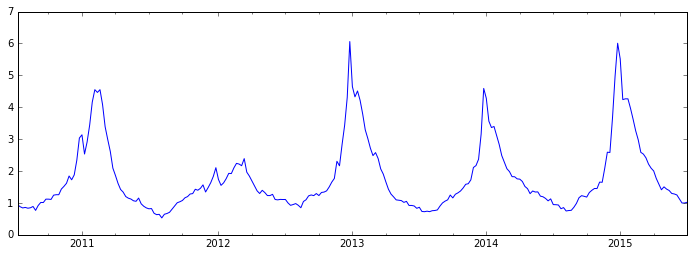

In [7]:
TRUTH_FLU.plot()

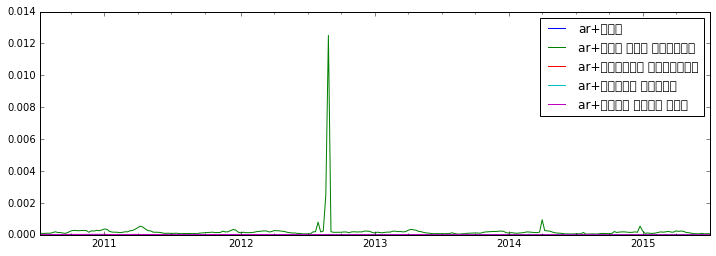

In [8]:
TS_ALL.iloc[:,:5].plot()

## Summarize distance from root

Number of articles by distance from each root.

In [9]:
COUNTS = pd.DataFrame(columns=range(1,9), index=sorted(GRAPH.keys()))
COUNTS.fillna(0, inplace=True)
for (root, leaves) in GRAPH.items():
   for (leaf, dist) in leaves.items():
      COUNTS[dist][root] += 1
COUNTS

,1,2,3,4,5,6,7,8
ar+إنفلونزا,76,144,73,9,1,0,0,0
ar+حصبة,39,104,31,6,3,0,0,0
ar+حمى الضنك,20,101,105,53,4,3,0,0
ar+داء المتدثرات,4,3,4,6,0,0,0,0
ar+سعال ديكي,5,20,25,6,0,2,0,0
ar+ملاريا,24,71,47,7,2,0,0,0
de+Chlamydiose,13,28,54,15,16,1,0,0
de+Denguefieber,12,10,60,24,19,38,1,2
de+Influenza,9,14,26,51,18,13,2,0
de+Keuchhusten,10,21,47,13,10,0,0,0


Number of articles of at most the given distance.

In [10]:
COUNTS_CUM = COUNTS.cumsum(axis=1)
COUNTS_CUM

,1,2,3,4,5,6,7,8
ar+إنفلونزا,76,220,293,302,303,303,303,303
ar+حصبة,39,143,174,180,183,183,183,183
ar+حمى الضنك,20,121,226,279,283,286,286,286
ar+داء المتدثرات,4,7,11,17,17,17,17,17
ar+سعال ديكي,5,25,50,56,56,58,58,58
ar+ملاريا,24,95,142,149,151,151,151,151
de+Chlamydiose,13,41,95,110,126,127,127,127
de+Denguefieber,12,22,82,106,125,163,164,166
de+Influenza,9,23,49,100,118,131,133,133
de+Keuchhusten,10,31,78,91,101,101,101,101


# Parameter sweep

Return the set of articles with maximum category distance from a given root.

In [11]:
def articles_dist(root, dist):
   return { a for (a, d) in GRAPH[root].items() if d <= dist }

Return time series for articles with a maximum category distance from the given root.

In [12]:
def select_by_distance(root, d):
   keep_cols = articles_dist(root, d)
   return TS_ALL.filter(items=keep_cols, axis=1)

In [13]:
select_by_distance('en+Influenza', 1).head()

,en+Canine influenza,en+Influenza,en+Influenza treatment,en+Reassortment,en+Swine influenza,en+Antigenic shift,en+Influenzavirus C,en+Influenza research,en+Bronchiolitis,en+Adult T-cell leukemia/lymphoma,...,en+Norovirus,en+Influenza prevention,en+Hepatitis C,en+Cat flu,en+Equine influenza,en+Pandemrix,en+Hepatitis D,en+2007 Australian equine influenza outbreak,en+Common cold,en+Influenza-like illness
2010-07-04/2010-07-10,3.677000e-07,0.000010,3.396000e-07,2.251000e-07,0.000008,4.990000e-07,2.345000e-07,1.388000e-07,0.000001,3.208000e-07,...,0.000007,7.692000e-08,0.000021,2.214000e-07,2.308000e-07,2.214000e-07,0.000002,8.817000e-08,0.000009,4.071000e-07
2010-07-11/2010-07-17,4.334000e-07,0.000012,4.164000e-07,2.550000e-07,0.000009,4.603000e-07,2.062000e-07,1.574000e-07,0.000001,3.975000e-07,...,0.000005,6.476000e-08,0.000026,2.072000e-07,2.989000e-07,2.212000e-07,0.000002,9.863000e-08,0.000009,5.081000e-07
2010-07-18/2010-07-24,4.267000e-07,0.000012,4.423000e-07,2.449000e-07,0.000018,6.076000e-07,2.293000e-07,1.541000e-07,0.000001,4.552000e-07,...,0.000007,8.308000e-08,0.000028,2.155000e-07,2.709000e-07,1.991000e-07,0.000002,1.021000e-07,0.000010,5.184000e-07
2010-07-25/2010-07-31,4.056000e-07,0.000012,5.073000e-07,2.502000e-07,0.000009,5.498000e-07,2.376000e-07,1.679000e-07,0.000001,4.237000e-07,...,0.000005,7.595000e-08,0.000027,2.300000e-07,2.829000e-07,1.965000e-07,0.000002,1.366000e-07,0.000010,5.498000e-07
2010-08-01/2010-08-07,4.142000e-07,0.000013,4.966000e-07,3.056000e-07,0.000012,5.495000e-07,2.596000e-07,1.607000e-07,0.000001,4.609000e-07,...,0.000004,1.174000e-07,0.000026,2.177000e-07,3.091000e-07,1.916000e-07,0.000002,1.106000e-07,0.000010,6.181000e-07


Fit function. The core is the same as the `model_options` one, with non-constant training series set and a richer summary.

In [20]:
def fit(root, train_week_ct, d, alg, plot=True):
   ts_all = select_by_distance(root, d)
   ts_train = ts_all.iloc[:train_week_ct,:]
   truth_train = TRUTH_FLU.iloc[:train_week_ct]
   m = alg.fit(ts_train, truth_train)
   m.input_ct = len(ts_all.columns)
   pred = m.predict(ts_all)
   pred_s = pd.Series(pred, index=TRUTH_FLU.index)
   m.r = TRUTH_FLU.corr(pred_s)
   m.rmse = ((TRUTH_FLU - pred_s)**2).mean()
   m.nonzero = np.count_nonzero(m.coef_)
   if (not hasattr(m, 'l1_ratio_')):
      m.l1_ratio_ = -1
   # this is just a line to show how long the training period is
   train_period = TRUTH_FLU.iloc[:train_week_ct].copy(True)
   train_period[:] = 0
   if (plot):
      pd.DataFrame({'truth':       TRUTH_FLU,
                    'prediction':  pred,
                    'training pd': train_period}).plot(ylim=(-1,9))
   sumry = pd.DataFrame({'coefs': m.coef_,
                         'coefs_abs': np.abs(m.coef_)},
                        index=ts_all.columns)
   sumry.sort_values(by='coefs_abs', ascending=False, inplace=True)
   sumry = sumry.loc[:, 'coefs']
   for a in ('intercept_', 'alpha_', 'l1_ratio_', 'nonzero', 'rmse', 'r', 'input_ct'):
      try:
         sumry = pd.Series([getattr(m, a)], index=[a]).append(sumry)
      except AttributeError:
         pass
   return (m, pred, sumry)

Which 𝛼 and 𝜌 to explore? Same as `model_options`.

In [21]:
ALPHAS = np.logspace(-15, 2, 25)
RHOS = np.linspace(0.1, 0.9, 9)

Try all distance filters and summarize the result in a table.

In [22]:
def fit_summary(root, label, train_week_ct, alg, **kwargs):
   result = pd.DataFrame(columns=[[label] * 4,
                                  ['input_ct', 'rmse', 'rho', 'nonzero']],
                         index=range(1, 9))
   preds = dict()
   for d in range(1, 9):
      (m, preds[d], sumry) = fit(root, train_week_ct, d, alg(**kwargs), plot=False)
      result.loc[d,:] = (m.input_ct, m.rmse, m.l1_ratio_, m.nonzero)
   return (result, preds)

## Lasso, normalized, positive, auto 𝛼

In [23]:
la_npa = fit_summary('en+Influenza', 'la_npa', 104, sk.linear_model.LassoCV,
                      normalize=True, positive=True, alphas=ALPHAS,
                      max_iter=1e5, selection='random', n_jobs=-1)
la_npa[0]

la_npa                      
  input_ct      rmse rho nonzero
1       32   0.85181  -1       5
2      162  0.423396  -1       6
3      385  0.421616  -1       7
4      504  0.421472  -1       7
5      562  0.421593  -1       7
6      570  0.422126  -1       7
7      571  0.422021  -1       8
8      571  0.421677  -1       7

input_ct                                                            32.000000
r                                                                    0.591671
rmse                                                                 0.851699
nonzero                                                              5.000000
l1_ratio_                                                           -1.000000
alpha_                                                               0.005623
intercept_                                                          -0.025942
en+Influenzavirus C                                             665758.298050
en+Influenzavirus B                                             564721.829660
en+Bronchiolitis                                                299406.908302
en+Influenza treatment                                           12353.960484
en+Influenza                                                      1939.560993
en+Canine influenza                                             

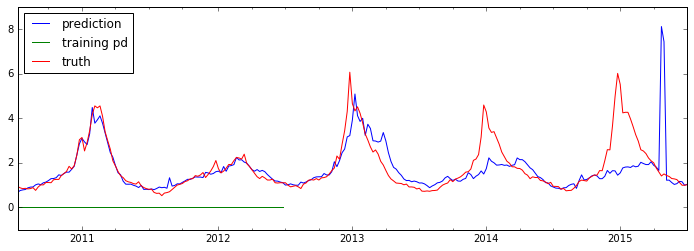

In [24]:
(m, _, s) = fit('en+Influenza', 104, 1,
                sk.linear_model.LassoCV(normalize=True, positive=True, alphas=ALPHAS,
                                        max_iter=1e5, selection='random', n_jobs=-1))
s.head(27)

input_ct                                   162.000000
r                                            0.808813
rmse                                         0.423246
nonzero                                      6.000000
l1_ratio_                                   -1.000000
alpha_                                       0.005623
intercept_                                   0.040238
en+Influenzavirus B                     308839.224752
en+Oseltamivir                          242121.103904
en+Astrovirus                           206288.629263
en+Human respiratory syncytial virus     95860.294588
en+Bronchiolitis                         71425.420044
en+Influenza                               774.419155
en+Interferon                                0.000000
en+Infectious mononucleosis                  0.000000
en+Viral disease                             0.000000
en+Sore throat                               0.000000
en+Richard Shope                             0.000000
en+Cholera                  

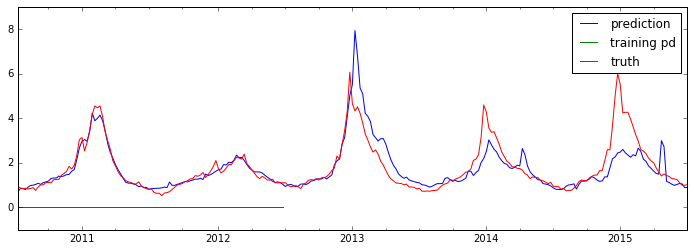

In [25]:
(m, _, s) = fit('en+Influenza', 104, 2,
                sk.linear_model.LassoCV(normalize=True, positive=True, alphas=ALPHAS,
                                        max_iter=1e5, selection='random', n_jobs=-1))
s.head(27)

input_ct                                    385.000000
r                                             0.810147
rmse                                          0.422226
nonzero                                       8.000000
l1_ratio_                                    -1.000000
alpha_                                        0.005623
intercept_                                    0.023569
en+Influenzavirus B                      307278.945067
en+Oseltamivir                           248650.955817
en+Astrovirus                            192382.030474
en+Human respiratory syncytial virus      96685.599159
en+Bronchiolitis                          61550.704919
en+Croup                                   4297.096784
en+Laryngitis                              1257.290744
en+Influenzavirus C                         849.631059
en+Epizootic                                  0.000000
en+Transmission and infection of H5N1         0.000000
en+Feline viral rhinotracheitis               0.000000
en+Nasal s

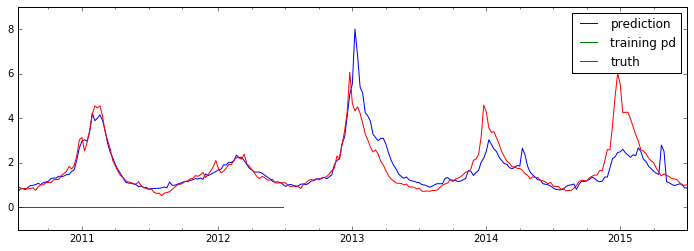

In [26]:
(m, _, s) = fit('en+Influenza', 104, 3,
                sk.linear_model.LassoCV(normalize=True, positive=True, alphas=ALPHAS,
                                        max_iter=1e5, selection='random', n_jobs=-1))
s.head(27)

## Elastic net, normalized, positive, auto 𝛼, auto 𝜌

In [27]:
en_npaa = fit_summary('en+Influenza', 'en_npaa', 104, sk.linear_model.ElasticNetCV,
                      normalize=True, positive=True, alphas=ALPHAS, l1_ratio=RHOS,
                      max_iter=1e5, selection='random', n_jobs=-1)
en_npaa[0]

en_npaa                       
  input_ct      rmse  rho nonzero
1       32  0.710605  0.9       5
2      162  0.389561  0.9      10
3      385  0.390526  0.9      13
4      504  0.390381  0.9      13
5      562  0.390718  0.9      13
6      570  0.390618  0.9      13
7      571  0.390572  0.9      13
8      571  0.390522  0.9      13

input_ct                                                             32.000000
r                                                                     0.653963
rmse                                                                  0.710464
nonzero                                                               5.000000
l1_ratio_                                                             0.900000
alpha_                                                                0.005623
intercept_                                                           -0.201769
en+Influenzavirus C                                             1435126.718303
en+Influenzavirus B                                              481107.828793
en+Bronchiolitis                                                 237769.587471
en+Influenza treatment                                           113447.354086
en+Influenza                                                       8040.737162
en+Canine influenza                                 

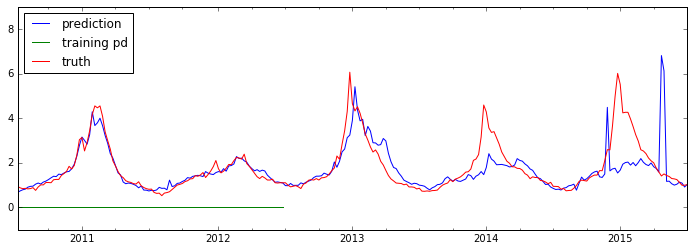

In [28]:
(m, _, s) = fit('en+Influenza', 104, 1,
                sk.linear_model.ElasticNetCV(normalize=True, positive=True,
                                             alphas=ALPHAS, l1_ratio=RHOS,
                                             max_iter=1e5, selection='random', n_jobs=-1))
s.head(27)

input_ct                                   162.000000
r                                            0.822938
rmse                                         0.389294
nonzero                                     10.000000
l1_ratio_                                    0.900000
alpha_                                       0.005623
intercept_                                  -0.044469
en+Influenzavirus C                     504409.350529
en+Influenzavirus B                     259325.879589
en+Oseltamivir                          220662.878206
en+Astrovirus                            97964.349420
en+Human respiratory syncytial virus     93739.267837
en+Bronchiolitis                         69069.768615
en+Influenza A virus                     18147.456379
en+Influenza treatment                    7759.064607
en+Influenza                              3736.502697
en+Sore throat                            2423.281224
en+Richard Shope                             0.000000
en+Cholera                  

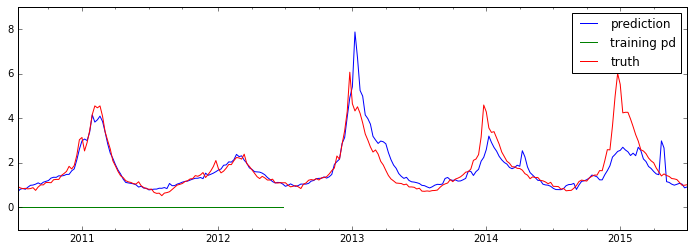

In [29]:
(m, _, s) = fit('en+Influenza', 104, 2,
                sk.linear_model.ElasticNetCV(normalize=True, positive=True,
                                             alphas=ALPHAS, l1_ratio=RHOS,
                                             max_iter=1e5, selection='random', n_jobs=-1))
s.head(27)

input_ct                                            385.000000
r                                                     0.822332
rmse                                                  0.390587
nonzero                                              13.000000
l1_ratio_                                             0.900000
alpha_                                                0.005623
intercept_                                           -0.067339
en+Influenzavirus C                              511059.357752
en+Influenzavirus B                              258411.593300
en+Oseltamivir                                   220624.342137
en+Human respiratory syncytial virus              94172.731116
en+Astrovirus                                     74096.910623
en+Bronchiolitis                                  68759.890364
en+Viral encephalitis                             22021.338431
en+Influenza A virus                              19527.220552
en+Influenza treatment                             7943

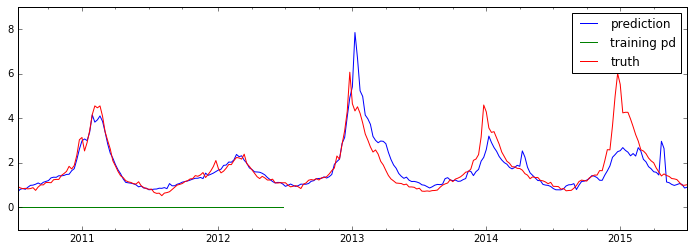

In [30]:
(m, _, s) = fit('en+Influenza', 104, 3,
                sk.linear_model.ElasticNetCV(normalize=True, positive=True,
                                             alphas=ALPHAS, l1_ratio=RHOS,
                                             max_iter=1e5, selection='random', n_jobs=-1))
s.head(27)

## Elastic net, normalized, positive, auto 𝛼, manual 𝜌 = ½

In [31]:
en_npam = fit_summary('en+Influenza', 'en_npam', 104, sk.linear_model.ElasticNetCV,
                      normalize=True, positive=True, alphas=ALPHAS, l1_ratio=0.5,
                      max_iter=1e5, selection='random', n_jobs=-1)
en_npam[0]

en_npam                       
  input_ct      rmse  rho nonzero
1       32  0.738359  0.5      11
2      162  0.527247  0.5      17
3      385  0.486709  0.5      23
4      504  0.474364  0.5      26
5      562  0.617935  0.5      18
6      570  0.618032  0.5      18
7      571  0.617998  0.5      18
8      571   0.61801  0.5      18

input_ct                                                             32.000000
r                                                                     0.656821
rmse                                                                  0.737210
nonzero                                                              11.000000
l1_ratio_                                                             0.500000
alpha_                                                                0.001101
intercept_                                                           -0.474304
en+Influenzavirus C                                             1515751.443092
en+Influenza virus nucleoprotein                                 635922.462467
en+Influenzavirus B                                              513402.566231
en+Canine influenza                                              279283.462613
en+Equine influenza                                              256546.198822
en+Bronchiolitis                                    

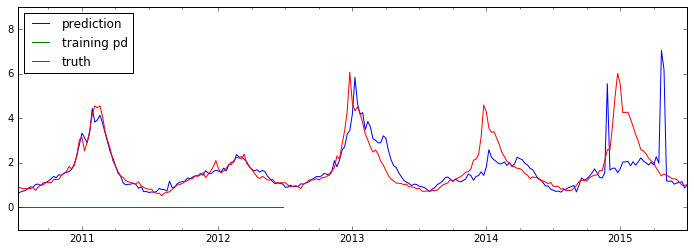

In [32]:
(m, _, s) = fit('en+Influenza', 104, 1,
                sk.linear_model.ElasticNetCV(normalize=True, positive=True,
                                             alphas=ALPHAS, l1_ratio=0.5,
                                             max_iter=1e5, selection='random', n_jobs=-1))
s.head(27)

input_ct                                    162.000000
r                                             0.772064
rmse                                          0.527285
nonzero                                      17.000000
l1_ratio_                                     0.500000
alpha_                                        0.005623
intercept_                                   -0.545451
en+Influenzavirus C                     1036439.486855
en+Patrick Laidlaw                       734337.031866
en+Influenzavirus B                      181087.336712
en+Influenza research                    172722.446854
en+Oseltamivir                           165083.182335
en+Influenza treatment                    89639.505487
en+Astrovirus                             78061.518304
en+Human respiratory syncytial virus      71081.636960
en+Bronchiolitis                          66351.250421
en+Influenza A virus                      62662.014524
en+Sore throat                            35723.657394
en+Upper r

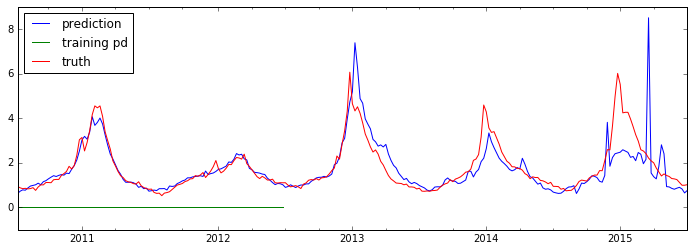

In [33]:
(m, _, s) = fit('en+Influenza', 104, 2,
                sk.linear_model.ElasticNetCV(normalize=True, positive=True,
                                             alphas=ALPHAS, l1_ratio=0.5,
                                             max_iter=1e5, selection='random', n_jobs=-1))
s.head(27)

input_ct                                    385.000000
r                                             0.786864
rmse                                          0.486693
nonzero                                      23.000000
l1_ratio_                                     0.500000
alpha_                                        0.005623
intercept_                                   -0.672222
en+Walter Fiers                         1095035.094420
en+Influenzavirus C                      917081.994541
en+Fujian flu                            254105.752536
en+Influenzavirus B                      178153.262873
en+Patrick Laidlaw                       162966.052939
en+Oseltamivir                           161783.326776
en+Influenza A virus subtype H3N8        107999.040892
en+Influenza treatment                    96260.627799
en+Viral encephalitis                     94245.866855
en+Human respiratory syncytial virus      70575.679240
en+Influenza A virus                      64060.398284
en+Bronchi

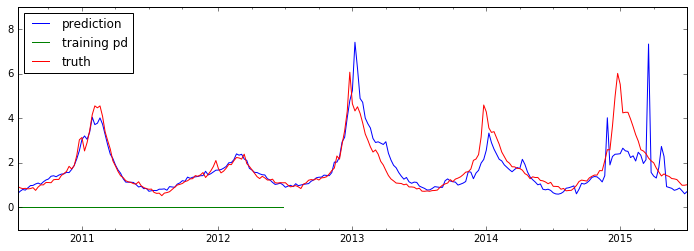

In [34]:
(m, _, s) = fit('en+Influenza', 104, 3,
                sk.linear_model.ElasticNetCV(normalize=True, positive=True,
                                             alphas=ALPHAS, l1_ratio=0.5,
                                             max_iter=1e5, selection='random', n_jobs=-1))
s.head(27)

## Summary

All the result tables next to one another.

In [35]:
pd.concat([la_npa[0], en_npaa[0], en_npam[0]], axis=1)

la_npa                        en_npaa                         en_npam  \
  input_ct      rmse rho nonzero input_ct      rmse  rho nonzero input_ct   
1       32   0.85181  -1       5       32  0.710605  0.9       5       32   
2      162  0.423396  -1       6      162  0.389561  0.9      10      162   
3      385  0.421616  -1       7      385  0.390526  0.9      13      385   
4      504  0.421472  -1       7      504  0.390381  0.9      13      504   
5      562  0.421593  -1       7      562  0.390718  0.9      13      562   
6      570  0.422126  -1       7      570  0.390618  0.9      13      570   
7      571  0.422021  -1       8      571  0.390572  0.9      13      571   
8      571  0.421677  -1       7      571  0.390522  0.9      13      571   

                          
       rmse  rho nonzero  
1  0.738359  0.5      11  
2  0.527247  0.5      17  
3  0.486709  0.5      23  
4  0.474364  0.5      26  
5  0.617935  0.5      18  
6  0.618032  0.5      18  
7  0.617998  0.5      18  
8   0.61801  0.5      18

Plot the predictions by distance filter next to one another.

In [36]:
def plot(data, ds):
   for d in ds:
      D = collections.OrderedDict([('truth', TRUTH_FLU)])
      D[d] = data[1][d]
      pd.DataFrame(D).plot(figsize=(12,3))

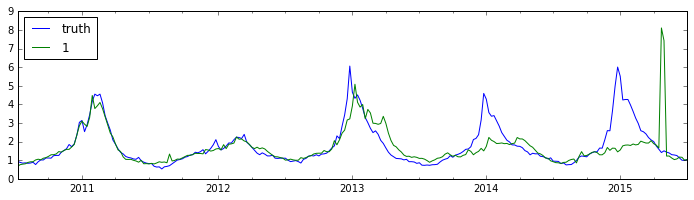

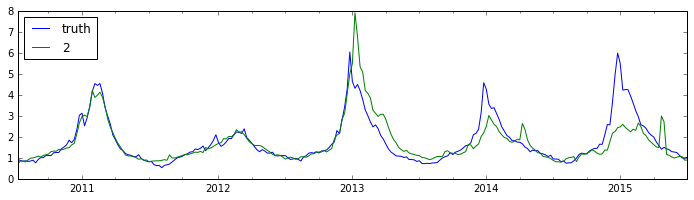

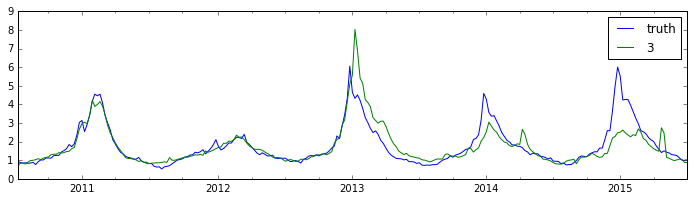

In [37]:
plot(la_npa, range(1, 4))

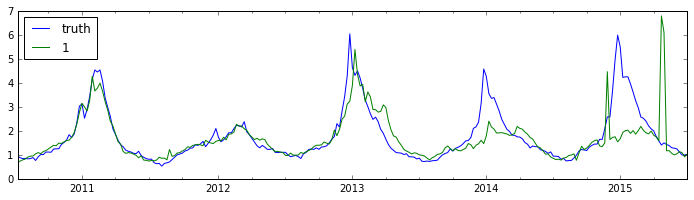

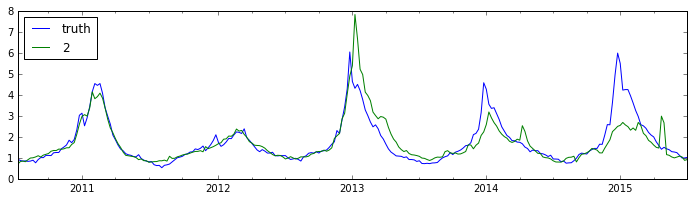

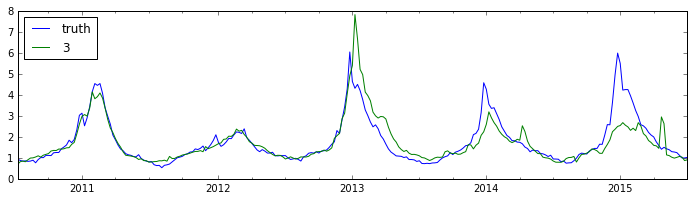

In [38]:
plot(en_npaa, range(1, 4))

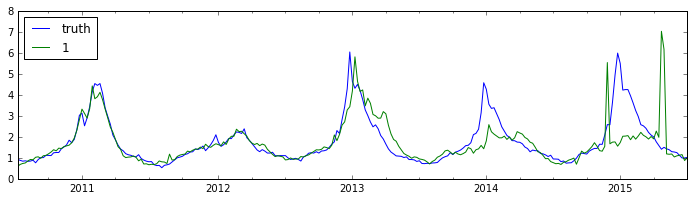

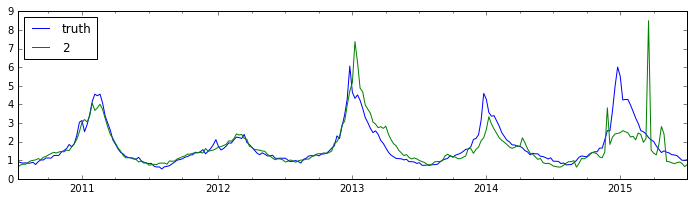

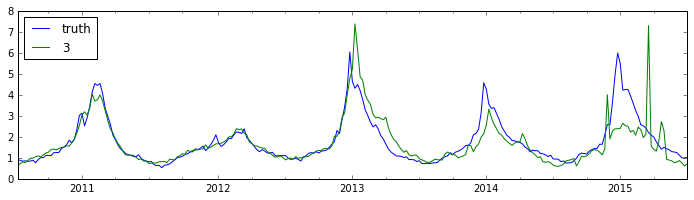

In [39]:
plot(en_npam, range(1, 4))